# Binary Classification with a Software Defects Dataset
### Kaggle Playground Series - Season 3 Episode 23
Predicting whether a piece of software will have a defect depending on the features of the software

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

# print(raw_test.info())
print(raw_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

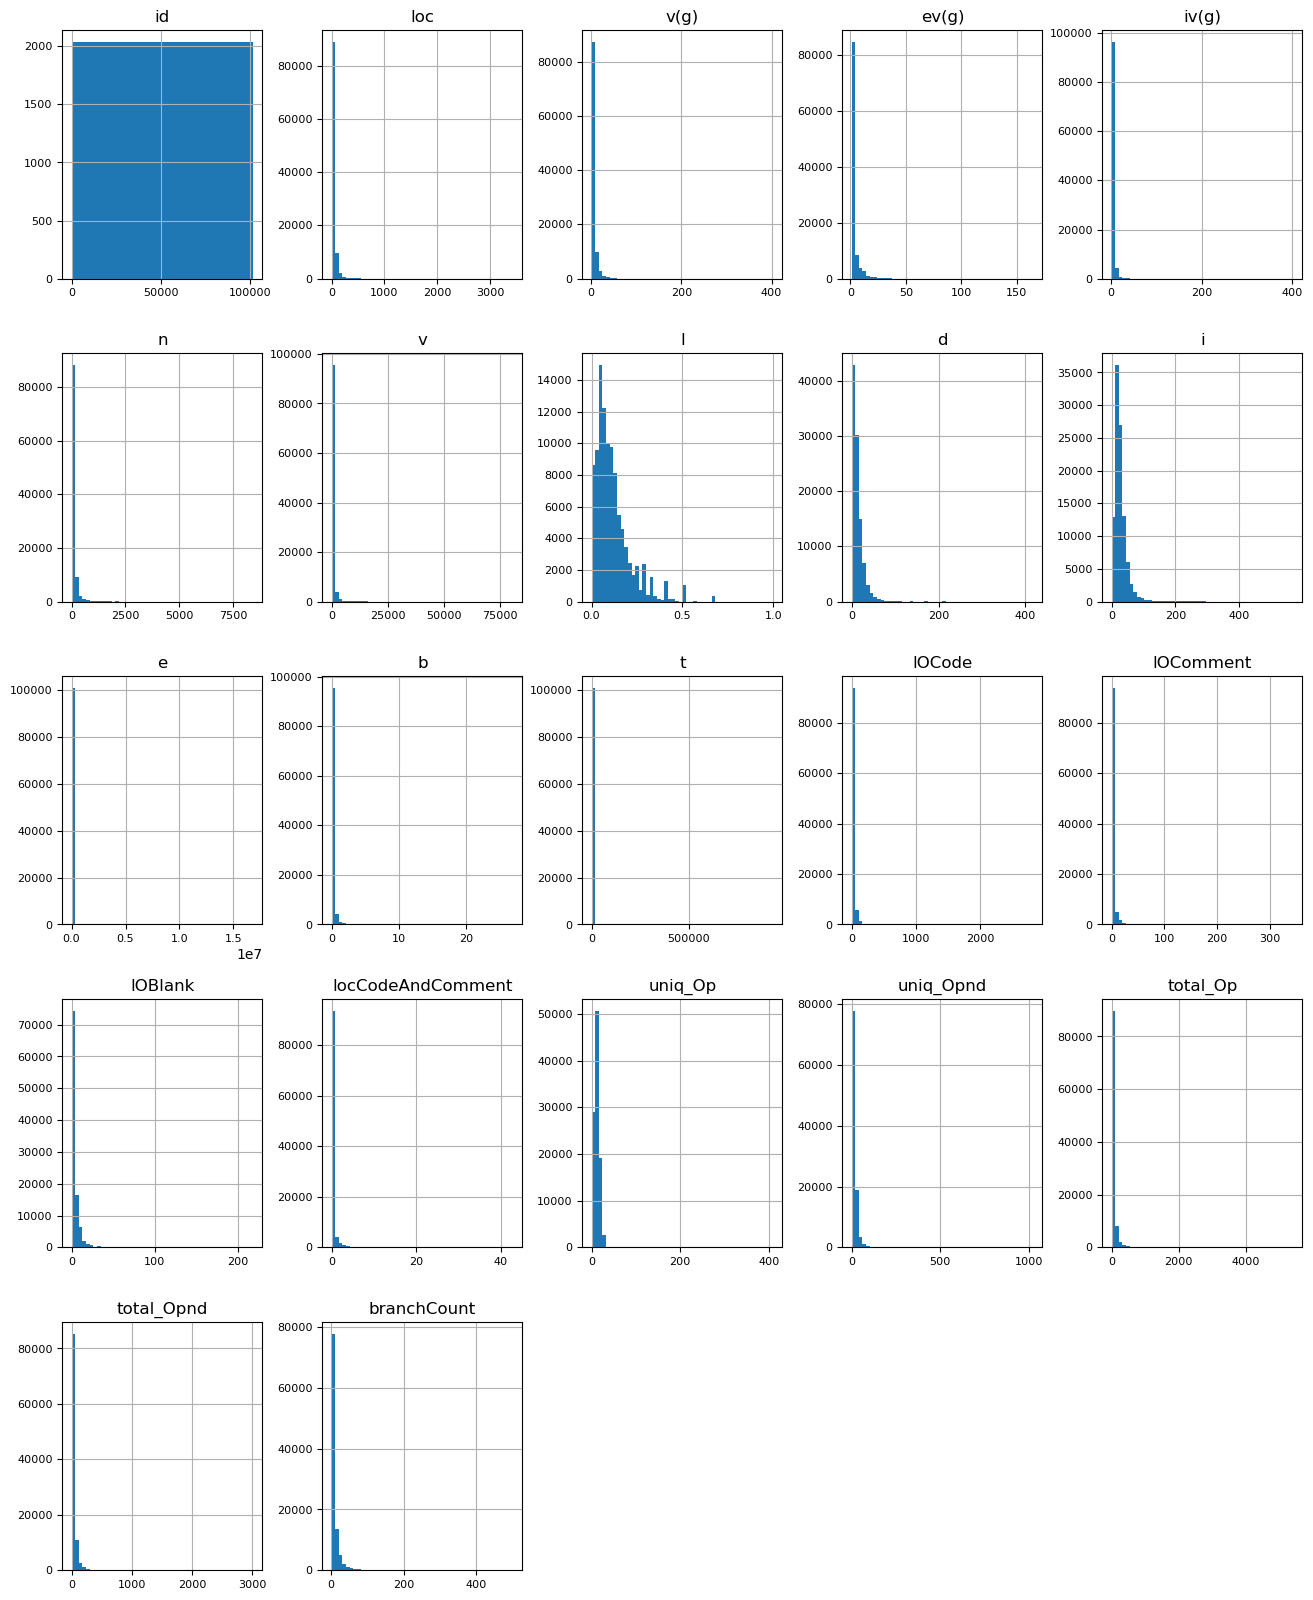

In [3]:
raw_train.hist(figsize=(16, 20),bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

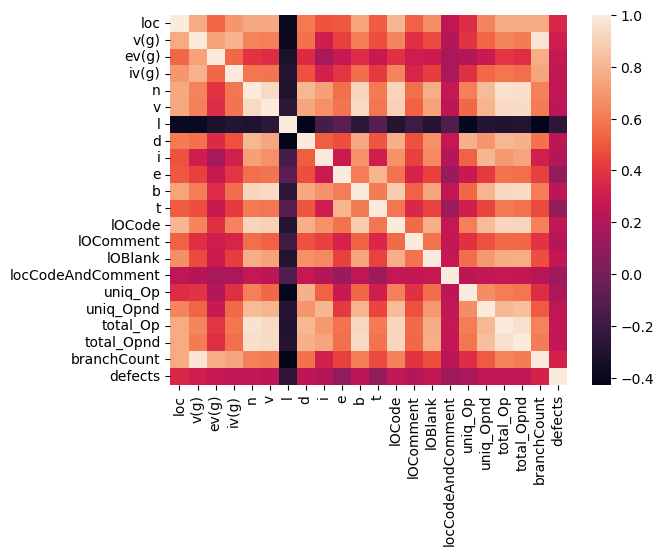

Redundant Features:
['v(g)', 'total_Op', 'total_Opnd', 'v', 'b', 'lOCode', 'uniq_Opnd', 'd']


In [4]:
# Find correlated features and remove to improve model performance - many of these are highly correlated so start with
## anything over 0.8

train_data = raw_train.drop('id', axis=1)
test_data = raw_test.drop('id', axis=1)

corrmat = train_data.corr()

sns.heatmap(corrmat)
plt.show()

correlated = []
redundant = []

for col in corrmat.columns:
    for row in corrmat.index:
        if col == row:
            break
            
        if abs(corrmat[col][row]) > 0.8:
            correlated.append([col,row])
            
correlated = sorted(correlated, key=lambda row: -corrmat[row[0]][row[1]])

for pair in correlated:  
    if pair[0] in redundant or pair[1] in redundant:
        pass
    else:      
        if corrmat.defects[pair[0]] > corrmat.defects[pair[1]]:
            redundant.append(pair[1])
    
        else:
            redundant.append(pair[0])
        
print('Redundant Features:')        
print(redundant)

train_data.drop(redundant, axis=1, inplace=True)
test_data.drop(redundant, axis=1, inplace=True)

In [5]:
# Investigate skew and see if I can do anything about it

for col in train_data:
    if train_data[col].skew() > 10:      
        train_data[col] = train_data[col].apply(lambda x: np.log(x + 1))
        test_data[col] = test_data[col].apply(lambda x: np.log(x + 1))
        print(f'{col} skew = {train_data[col].skew()}')
    
    
# train_data.hist(bins=50, figsize=(50,50))
# plt.show()

loc skew = 0.5082717041837402
iv(g) skew = 1.1886805709375847
e skew = -1.098969564173538
t skew = -0.2722663447090918
lOComment skew = 1.8637247536796346
locCodeAndComment skew = 4.374283791928858


In [6]:
# Normalise and Split

X = train_data.drop('defects', axis=1)
y = train_data.defects

ct = ColumnTransformer([('scale', StandardScaler(), X.columns)])

X = pd.DataFrame(ct.fit_transform(X), columns=X.columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state = 10)

X_test = pd.DataFrame(ct.transform(test_data), columns=test_data.columns)

In [23]:
# Model Select

pipeline = Pipeline([('clf', AdaBoostClassifier())])

model_1 = {'clf': [AdaBoostClassifier(random_state=10)], 'clf__n_estimators':[50, 100]}
model_2 = {'clf': [GradientBoostingClassifier(random_state=10)], 'clf__max_depth':[3, 5]}
model_3 = {'clf': [RandomForestClassifier(random_state=10)], 'clf__criterion':['gini', 'entropy']}

model_grid = [model_1, model_2, model_3]

model_select = GridSearchCV(pipeline, model_grid, cv=5, verbose=3, scoring='accuracy')


model_select.fit(X_train, y_train)

print(model_select.best_estimator_)
print(model_select.best_estimator_.score(X_val, y_val))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=50;, score=0.815 total time=   1.9s
[CV 2/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=50;, score=0.810 total time=   1.9s
[CV 3/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=50;, score=0.811 total time=   1.9s
[CV 4/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=50;, score=0.808 total time=   1.8s
[CV 5/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=50;, score=0.815 total time=   1.9s
[CV 1/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=100;, score=0.815 total time=   3.7s
[CV 2/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=100;, score=0.810 total time=   3.7s
[CV 3/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=100;, score=0.810 total time=   3.7s
[CV 4/5] END clf=AdaBoostClassifier(random_state=10), clf__n_estimators=1

In [29]:
# Fine-Tune Model

model = model_select.best_estimator_

tuning_grid = {'clf__learning_rate': [0.1, 0.5],
               'clf__n_estimators': [100, 200],
               'clf__ccp_alpha': [0, 1]}

fine_tune = GridSearchCV(model, tuning_grid, cv=5, verbose=3, scoring='accuracy')

fine_tune.fit(X_train, y_train)

tuned_model = fine_tune.best_estimator_

print(f'Model: {tuned_model}')
print(f'Best CV Score: {fine_tune.best_score_}')
print(f'Validation Score: {tuned_model.score(X_val, y_val)}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=100;, score=0.817 total time=   8.0s
[CV 2/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=100;, score=0.812 total time=   7.9s
[CV 3/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=100;, score=0.812 total time=   7.9s
[CV 4/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=100;, score=0.811 total time=   7.8s
[CV 5/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=100;, score=0.820 total time=   7.9s
[CV 1/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=200;, score=0.817 total time=  15.6s
[CV 2/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=200;, score=0.812 total time=  14.8s
[CV 3/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__n_estimators=200;, score=0.812 total time=  14.6s
[CV 4/5] END clf__ccp_alpha=0, clf__learning_rate=0.1, clf__

In [30]:
# Predict outcomes

predictions = pd.DataFrame()

predictions['id'] = raw_test.id
predictions['defects'] = tuned_model.predict_proba(X_test)[:,1]

print(predictions)

predictions.to_csv('predictions.csv', index=False)

           id   defects
0      101763  0.254752
1      101764  0.207424
2      101765  0.685099
3      101766  0.452658
4      101767  0.150086
...       ...       ...
67837  169600  0.274574
67838  169601  0.107372
67839  169602  0.178243
67840  169603  0.101517
67841  169604  0.741272

[67842 rows x 2 columns]
